In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def convert_pd(file: str) -> pd.DataFrame:
    """
    Convert a text file to a pandas DataFrame.

    Args:
        file (str): Path to the text file.

    Returns:
        pd.DataFrame: DataFrame containing the data from the text file.
    """
    df = pd.read_csv(file, header=None, delim_whitespace=True)
    return df

def get_y(file: str) -> np.ndarray:
    """
    Extract a list of values from a text file.

    Args:
        file (str): Path to the text file.

    Returns:
        np.ndarray: Array containing the values from the file.
    """
    with open(file, 'r') as f:
        values = f.read().splitlines()
    return np.array(values, dtype=int) - 1

y_train = get_y('../train/y_train.txt')
y_test = get_y('../test/y_test.txt')

cols = ["body_acc_x", "body_acc_y", "body_acc_z", "body_gyro_x", "body_gyro_y", "body_gyro_z", "total_acc_x", "total_acc_y", "total_acc_z"]
labels = ['Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing', 'Laying']

In [6]:
def batch_convert(train: str):
    l = []
    for name in cols:
        p = convert_pd(f"../{train}/Inertial Signals/{name}_{train}.txt")
        l += [p]
    return l

In [4]:
def get_by_item(data: list, num: int):
    rows = []
    for i in range(len(data)):
        rows.append(data[i].iloc[num, ].to_numpy())
    df = pd.DataFrame(rows)
    df = df.transpose()
    df.columns = cols
    return df

In [5]:
from tqdm import tqdm

groups = [("body_acc_x", "body_acc_y", "body_acc_z"), ("body_gyro_x", "body_gyro_y", "body_gyro_z"), ("total_acc_x", "total_acc_y", "total_acc_z")]
def get_whole_dataset(data: list, y: np.ndarray, minmax: int = 0) -> pd.DataFrame:
    """
    Get all data samples, concattenate them into one single DataFrame.
    Args:
        minmax (int): If 0: no-applied, 1: MinMax applied for features, 2: MinMax applied on groups of features
    """
    cols = ["body_acc_x", "body_acc_y", "body_acc_z", "body_gyro_x", "body_gyro_y", "body_gyro_z", "total_acc_x", "total_acc_y", "total_acc_z", "sample_id", "label"]
    id = 0
    total_df = []
    print(f"Extracting with MinMax: {minmax}")
    for i in tqdm(range(len(data[0])), desc="Processing samples"):
        df = {}
        if minmax == 2:
            # Find min-max for each group
            for group in groups:
                group_min = np.min([data[cols.index(feature)].iloc[i, ].min() for feature in group])
                group_max = np.max([data[cols.index(feature)].iloc[i, ].max() for feature in group])
                for feature in group:
                    df[feature] = (data[cols.index(feature)].iloc[i, ].to_numpy() - group_min) / (group_max - group_min)
            df["sample_id"] = id
            df["label"] = y[i]
        elif minmax == 1:
            df = {
                "body_acc_x": (data[0].iloc[i, ].to_numpy() - data[0].iloc[i, ].min()) / (data[0].iloc[i, ].max() - data[0].iloc[i, ].min()),
                "body_acc_y": (data[1].iloc[i, ].to_numpy() - data[1].iloc[i, ].min()) / (data[1].iloc[i, ].max() - data[1].iloc[i, ].min()),
                "body_acc_z": (data[2].iloc[i, ].to_numpy() - data[2].iloc[i, ].min()) / (data[2].iloc[i, ].max() - data[2].iloc[i, ].min()),
                "body_gyro_x": (data[3].iloc[i, ].to_numpy() - data[3].iloc[i, ].min()) / (data[3].iloc[i, ].max() - data[3].iloc[i, ].min()),
                "body_gyro_y": (data[4].iloc[i, ].to_numpy() - data[4].iloc[i, ].min()) / (data[4].iloc[i, ].max() - data[4].iloc[i, ].min()),
                "body_gyro_z": (data[5].iloc[i, ].to_numpy() - data[5].iloc[i, ].min()) / (data[5].iloc[i, ].max() - data[5].iloc[i, ].min()),
                "total_acc_x": (data[6].iloc[i, ].to_numpy() - data[6].iloc[i, ].min()) / (data[6].iloc[i, ].max() - data[6].iloc[i, ].min()),
                "total_acc_y": (data[7].iloc[i, ].to_numpy() - data[7].iloc[i, ].min()) / (data[7].iloc[i, ].max() - data[7].iloc[i, ].min()),
                "total_acc_z": (data[8].iloc[i, ].to_numpy() - data[8].iloc[i, ].min()) / (data[8].iloc[i, ].max() - data[8].iloc[i, ].min()),
                "sample_id": id,
                "label": y[i]
            }
        else:
            df = {
                "body_acc_x": data[0].iloc[i, ].to_numpy(),
                "body_acc_y": data[1].iloc[i, ].to_numpy(),
                "body_acc_z": data[2].iloc[i, ].to_numpy(),
                "body_gyro_x": data[3].iloc[i, ].to_numpy(),
                "body_gyro_y": data[4].iloc[i, ].to_numpy(),
                "body_gyro_z": data[5].iloc[i, ].to_numpy(),
                "total_acc_x": data[6].iloc[i, ].to_numpy(),
                "total_acc_y": data[7].iloc[i, ].to_numpy(),
                "total_acc_z": data[8].iloc[i, ].to_numpy(),
                "sample_id": id,
                "label": y[i]
            }
        total_df.append(df)
        id += 1
    df = pd.DataFrame(total_df)
    df.columns = cols
    return df

In [18]:
def row_to_df(row):
    """
    A row contains many arrays in cells, convert it to a DataFrame.
    """
    label = row['label']
    sample_id = row['sample_id']
    data = row.drop(['label', 'sample_id'])
    data = data.apply(pd.Series)
    return data.T, label, sample_id

def plot_data(num: int, data: pd.DataFrame, allowed_features: list = cols):
    """
    Plot data with line plot
    """
    data, label, sample_id = row_to_df(data.iloc[num])
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(allowed_features):
        plt.plot(data.iloc[:, i], label=col)
    plt.ylim(0,1)
    plt.title(f"Sample ID: {sample_id}, Label: {labels[label]}")
    plt.legend()
    plt.show()

In [11]:
test = batch_convert("test")
test_df = get_whole_dataset(test, y_test, minmax=2)

C:\Users\tungq\AppData\Local\Temp\ipykernel_63924\4212258228.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, header=None, delim_whitespace=True)
C:\Users\tungq\AppData\Local\Temp\ipykernel_63924\4212258228.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, header=None, delim_whitespace=True)
C:\Users\tungq\AppData\Local\Temp\ipykernel_63924\4212258228.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, header=None, delim_whitespace=True)
C:\Users\tungq\AppData\Local\Temp\ipykernel_63924\4212258228.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use

Extracting with MinMax: 2


Processing samples: 100%|██████████| 2947/2947 [00:04<00:00, 600.89it/s]


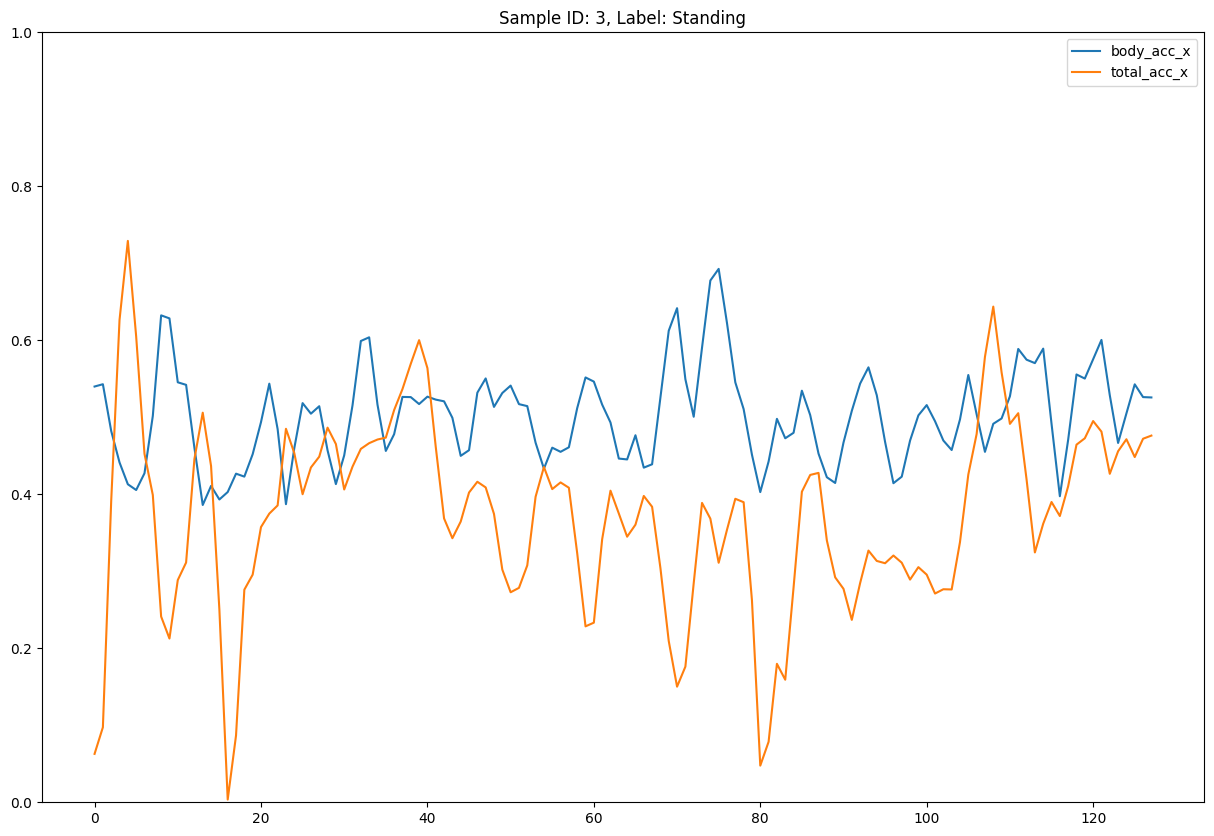

In [19]:
# plot_data(3, test_df, allowed_features=["body_acc_x", "body_acc_y", "body_acc_z", "total_acc_x", "total_acc_y", "total_acc_z"])
plot_data(3, test_df, allowed_features=["body_acc_x", "total_acc_x"])

We can't see any direct relation between 